<a href="https://colab.research.google.com/github/smharwood/chaos-game/blob/master/GAN_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

This tutorial (from https://www.tensorflow.org/tutorials/generative/dcgan) demonstrates how to generate images using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

TODO:

- Play with batch size? May need to be smaller for larger image size
- Generator/discriminator capacity?
- Plot losses to figure out balance gen vs disc?

## Setup

In [1]:
import os, glob, time
import numpy as np
import matplotlib.pyplot as plt
import imageio, PIL
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display

tf.__version__

'2.8.0'

### Load and prepare the dataset

Upload custom dataset

In [2]:
BUFFER_SIZE = 6000
BATCH_SIZE = 64
images_dir = "images"

image_size = 32

In [3]:
from google.colab import files, drive

# mount Drive
mount_point = "/content/drive"
drive.mount(mount_point, force_remount=False)

# Get dataset as zipfile - either upload or find in Drive 
if False:
  uploaded = files.upload()
  zip_name = list(uploaded.keys())[0]
  assert zip_name.split('.')[1] == "zip", "Expecting a zipfile"
else:
  zip_name = mount_point + "/MyDrive/chaosGAN/images_{}.zip".format(image_size)

Mounted at /content/drive


In [4]:
import zipfile

# Extract files from zip -- expecting a "flat" file structure (no subdirectory)
with zipfile.ZipFile(zip_name, 'r') as zipObj:
  zipObj.extractall(images_dir)

In [5]:
image_files = glob.glob(images_dir+"/*.png")
ds_length = len(image_files)
print("Data directory: {}".format(images_dir))
print("First 5 image files in data dir: {}".format(image_files[:5]))

Data directory: images
First 5 image files in data dir: ['images/9989.png', 'images/6694.png', 'images/9459.png', 'images/4475.png', 'images/3790.png']


In [6]:
#img_height = image_size
#img_width = image_size
def _preprocess(img_name):
  # take filename string, read file,
  # decode bytes to appropriate image format as a 3D(?) uint8 tensor,
  # resize, 
  # and map to [-1,1]
  img = tf.io.read_file(img_name)
  img = tf.io.decode_png(img, channels=1)
  #img = tf.image.resize(img, [img_height, img_width])
  return (tf.cast(img, tf.float32) - 127.5) / 127.5

In [7]:
# Map, batch and shuffle the data
train_dataset = (tf.data.Dataset.from_tensor_slices(image_files)
                  .map(_preprocess)
                  .cache()
                  .shuffle(BUFFER_SIZE)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE)
                )

In [8]:
# MNIST FOR TESTING
#BUFFER_SIZE = 60000
#BATCH_SIZE = 256
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh (which ensures outputs are in [-1,1]).

The chaos game that generates the dataset is controlled by about 20 uniformly random parameters.
No real need for a huge hidden dimension.

In [9]:
noise_dim = 16

In [10]:
def get_DenseDefault(output_size, l2_weight):
  return layers.Dense(output_size,
                      kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                      bias_regularizer=tf.keras.regularizers.L2(l2_weight))
  
def get_Conv2DTransposeDefault(filters, kernel_size, strides, l2_weight, activation=None):
  return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same',
                       activation=activation,
                       kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                       bias_regularizer=tf.keras.regularizers.L2(l2_weight))
  
def get_Conv2DDefault(filters, kernel_size, strides, l2_weight, activation=None):
  return layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                       activation=activation,
                       kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                       bias_regularizer=tf.keras.regularizers.L2(l2_weight))

In [11]:
def make_generator_model_28(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(noise_dim,),
                           use_bias=False,
                           kernel_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(7*7*256, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(get_Conv2DTransposeDefault(64, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 14, 14, 64)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DTransposeDefault(64, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 28, 28, 64)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #model.add(get_Conv2DTransposeDefault(1, (5, 5), strides=(2, 2), l2_weight=l2_weight, activation='tanh'))
    model.add(get_Conv2DDefault(1, (4, 4), strides=(1, 1), l2_weight=0.0, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [12]:
def make_generator_model_32(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(noise_dim,),
                           use_bias=False,
                           kernel_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(8*8*16, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 16)))
    assert model.output_shape == (None, 8, 8, 16)  # Note: None is the batch size

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 16, 16, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 32, 32, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DDefault(1, (4, 4), strides=(1, 1), l2_weight=0.0, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [13]:
def make_generator_model_128(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(noise_dim,),
                           use_bias=False,
                           kernel_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(8*8*16, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 16)))
    assert model.output_shape == (None, 8, 8, 16)  # Note: None is the batch size

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 16, 16, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 32, 32, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 64, 64, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DTransposeDefault(16, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    assert model.output_shape == (None, 128, 128, 16)
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(get_Conv2DDefault(1, (4, 4), strides=(1, 1), l2_weight=0.0, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

Use the (as yet untrained) generator to create an image.

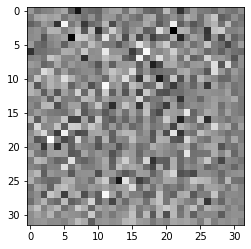

In [14]:
generator_dict = {28:  make_generator_model_28, 
                  32:  make_generator_model_32,
                  128: make_generator_model_128}
#generator = make_generator_model_28()
#generator = make_generator_model_32()
#generator = make_generator_model_128()
generator = generator_dict[image_size]()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.
Note: no final activation; output is in (-inf, inf).

In [15]:
def make_discriminator_model_28(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1],
                            kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                            bias_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(get_Conv2DDefault(128, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(get_DenseDefault(1024, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(1, l2_weight))

    return model

In [16]:
def make_discriminator_model_32(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 1],
                            kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                            bias_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(get_Conv2DDefault(128, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #model.add(get_Conv2DDefault(64, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(get_DenseDefault(1024, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(1, l2_weight))

    return model

In [17]:
def make_discriminator_model_128(l2_weight=2.5e-5):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same',
                            input_shape=[128, 128, 1],
                            kernel_regularizer=tf.keras.regularizers.L2(l2_weight),
                            bias_regularizer=tf.keras.regularizers.L2(l2_weight)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(get_Conv2DDefault(128, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #model.add(get_Conv2DDefault(64, (4, 4), strides=(2, 2), l2_weight=l2_weight))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(get_DenseDefault(1024, l2_weight))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(get_DenseDefault(1, l2_weight))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake.

In [18]:
discriminator_dict = {28:  make_discriminator_model_28, 
                      32:  make_discriminator_model_32,
                      128: make_discriminator_model_128}

#discriminator = make_discriminator_model_28()
#discriminator = make_discriminator_model_32()
#discriminator = make_discriminator_model_128()
discriminator = discriminator_dict[image_size]()

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00105863]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. Generally, we want the discriminator to output positive values for real images, and negative values for fake images.

We could interpret these real values as logits, and do a cross-entropy thing, but based on the ["Wasserstein GAN" paper](https://arxiv.org/abs/1701.07875) and the implementation in [TF-GAN](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/python/losses/losses_impl.py), we'll just look at the sum/mean of the difference between values on generated and real images.

In [20]:
#def discriminator_loss(real_output, fake_output):
#    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#    total_loss = real_loss + fake_loss
#    return total_loss
def discriminator_loss(real_output, fake_output):
    return tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output)

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (output a positive value).
Since this is a minimization problem, take the negative of the discriminator's output.

In [21]:
#def generator_loss(fake_output):
#    return cross_entropy(tf.ones_like(fake_output), fake_output)
def generator_loss(fake_output):
    return -tf.math.reduce_mean(fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [22]:
steps_per_epoch = ds_length / BATCH_SIZE

# A PRETTY GOOD BASELINE (32 batch size)
#generator_optimizer = tf.keras.optimizers.Adam(5e-4, 0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

# THIS SEEMS TO WORK WELL...
base_gen_lr = 5e-4
gen_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [60*steps_per_epoch, 60*steps_per_epoch, 60*steps_per_epoch], 
    [base_gen_lr,        base_gen_lr/2,     base_gen_lr/3,     base_gen_lr/4])
generator_optimizer = tf.keras.optimizers.Adam(gen_lr_schedule, 0.5)
base_dis_lr = 1e-4
dis_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [60*steps_per_epoch, 60*steps_per_epoch, 60*steps_per_epoch], 
    [base_dis_lr,        base_dis_lr/2,     base_dis_lr/3,     base_dis_lr/4])
discriminator_optimizer = tf.keras.optimizers.Adam(dis_lr_schedule, 0.5)

# Slower progress but it kind of gets there
#generator_optimizer = tf.keras.optimizers.Adam(3e-4, 0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, 0.9)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [23]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Checkpoint Manager could be helpful for deleting old checkpoints
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [24]:
# Restore from checkpoint, if possible
if False:
  latest_checkpoint = tf.train.latest_checkpoint(os.path.abspath(checkpoint_dir))
  if latest_checkpoint is not None:
    checkpoint.restore(latest_checkpoint)

## Define the training loop


In [25]:
num_examples_to_generate = 16

# You will reuse this seed over time
# (to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Could probably combine these two steps into a call to `minimize()`
    # TODO: consider multiple steps?
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [27]:
def train(dataset, epochs, g_losses=None, d_losses=None):

  if g_losses is None: g_losses = []
  if d_losses is None: d_losses = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gloss, dloss = train_step(image_batch)
      g_losses.append(gloss)
      d_losses.append(dloss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return g_losses, d_losses

**Generate and save images**


In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
      plt.axis('off')

  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [29]:
def plot_losses(g_losses, d_losses):
  gl = np.asarray(g_losses)
  dl = np.asarray(d_losses)
  fig = plt.figure(figsize=(7, 4))
  plt.plot(gl, 'b', label='gen. loss = -disc(fake)')
  plt.plot(dl, 'r', label='disc. loss = disc(fake) - disc(real)')
  plt.plot(gl + dl, 'k', label='sum = -disc(real)')
  plt.legend()
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

In [30]:
g_losses = []
d_losses = []

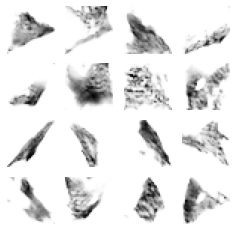

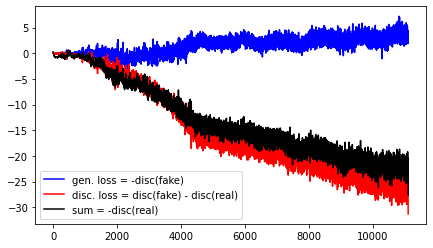

In [44]:
EPOCHS = 30

g_losses, d_losses = train(train_dataset, EPOCHS, g_losses, d_losses)
plot_losses(g_losses, d_losses)

## Create a GIF

Use `imageio` to create an animated gif using the images saved during training.

In [32]:
# Display a single image using the epoch number
#PIL.Image.open("image_at_epoch_{:04d}.png".format(EPOCHS))

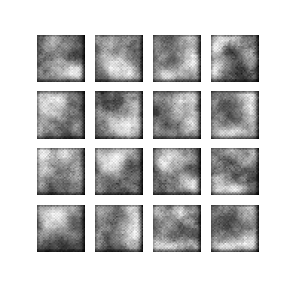

In [33]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display.Image(open(anim_file,'rb').read())

Save last checkpoint to Google drive

In [34]:
# files of last checkpoint:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint_files = glob.glob(latest_checkpoint+'*')
checkpoint_files.append(checkpoint_dir+"/checkpoint")

# copy to Drive
target_dir = mount_point+"/MyDrive/chaosGAN/ckpt_{}".format(image_size)
for f in checkpoint_files:
  !cp $f $target_dir

In [35]:
# To unmount:
# (make sure files have copied before unmounting)
#drive.flush_and_unmount()

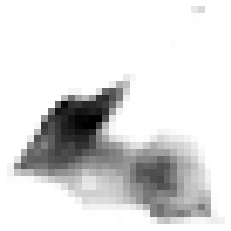

In [56]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.savefig("generated.png")
plt.show()